### Installation

pip installation and classical CARLA installation did not work for me, so here are the custom commands to get the development environment running


    conda create -n "CARLA-dev" python==3.7 pre-commit==2.9.2 pytest==6.1.2 sphinx==4.0.2 numpydoc==1.1.0 imageio==2.9.0 ipython==7.22.0 jinja2==2.11.3 networkx==2.5.1 scipy==1.6.2 markupsafe==2.0.1 protobuf<=3.21 lime==0.2.0.1 numpy==1.19.4 pandas==1.1.4 scikit-learn==0.23.2 tensorflow==1.14.0 pytorch==1.7.0 torchvision==0.8.1 h5py==2.10.0 xgboost==1.4.2 ipykernel pylint jupyter -c conda-forge -c pytorch 

    conda activate CARLA-dev

    pip install sphinx-rtd-theme==0.5.2 sphinx_autodoc_typehints==1.12.0 mip==1.12.0 recourse==1.0.0 dice-ml==0.5 causalgraphicalmodels==0.0.4 keras==2.3.0 








This .ipynb is based on the CARLA Tutorials:

    https://carla-counterfactual-and-recourse-library.readthedocs.io/en/latest/notebooks/how_to_use_carla.html
    https://carla-counterfactual-and-recourse-library.readthedocs.io/en/latest/notebooks/how_to_use_carla_causal.html
    https://carla-counterfactual-and-recourse-library.readthedocs.io/en/latest/notebooks/plotting_example.html
    https://carla-counterfactual-and-recourse-library.readthedocs.io/en/latest/notebooks/benchmark_example.html

but as some parts of these do not work, it is a stitched together version



In [1]:
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
import carla
from carla import logging
logger = carla.get_logger("carla")
logger.setLevel(logging.WARNING)

__name__ carla


Using TensorFlow backend.


[INFO] Using Python-MIP package version 1.12.0 [model.py <module>]


In [3]:

from carla.data.catalog import OnlineCatalog
import carla.evaluation.catalog as evaluation_catalog
from carla.models.catalog import MLModelCatalog
import carla.recourse_methods.catalog as recourse_catalog
from carla.models.negative_instances import predict_negative_instances
from carla import Benchmark

from matplotlib import pyplot as plt

### Example: Adult dataset with ANN model and Wachter recourse method

In [4]:
# load dataset
data_name = "adult"
dataset = OnlineCatalog(data_name)

In [5]:
# load catalog model
model_type = "ann"
ml_model = MLModelCatalog(
    dataset,
    model_type=model_type,
    load_online=True,
    backend="pytorch"
)

In [6]:
# define your recourse method
# hyperparams = {
#         "data_name": data_name,
#         "vae_params": {
#             "layers": [len(ml_model.feature_input_order), 512, 256, 8],
#         },
#     }
# recourse_method = recourse_catalog.CCHVAE(ml_model, hyperparams)

hyperparams = {"loss_type": "BCE", "binary_cat_features": True, "t_max_min": 0.02}
recourse_method = recourse_catalog.Wachter(ml_model, hyperparams)

In [7]:
# get some negative instances
factuals = predict_negative_instances(ml_model, dataset.df)
factuals = factuals[:50]

# find counterfactuals
counterfactuals = recourse_method.get_counterfactuals(factuals)

In [8]:
# first initialize the benchmarking class by passing
# black-box-model, recourse method, and factuals into it
benchmark = Benchmark(ml_model, recourse_method, factuals)

# now you can decide if you want to run all measurements
# or just specific ones.
evaluation_measures = [
    evaluation_catalog.YNN(benchmark.mlmodel, {"y": 5, "cf_label": 1}),
    evaluation_catalog.Distance(benchmark.mlmodel),
    evaluation_catalog.SuccessRate(),
    evaluation_catalog.Redundancy(benchmark.mlmodel, {"cf_label": 1}),
    evaluation_catalog.ConstraintViolation(benchmark.mlmodel),
    evaluation_catalog.AvgTime({"time": benchmark.timer}),
]

# now run all implemented measurements and create a
# DataFrame which consists of all results
results = benchmark.run_benchmark(evaluation_measures)

display(results.head(5))

,y-Nearest-Neighbours,L0_distance,L1_distance,L2_distance,Linf_distance,Success_Rate,Redundancy,Constraint_Violation,avg_time
0,0.163636,6.0,0.472695,0.037240,0.078842,0.44,1,1,1.852835
1,NaN,6.0,0.119658,0.002386,0.019956,NaN,5,1,NaN
2,NaN,6.0,0.179093,0.005346,0.029872,NaN,2,1,NaN
3,NaN,6.0,0.356108,0.021136,0.059395,NaN,1,1,NaN
4,NaN,6.0,0.119681,0.002387,0.019958,NaN,5,1,NaN


## Plotting

In the above section we got a dataset from the OnlineCatalog, and generated counterfactuals for a subset of that data. However sometimes it happens that recourse is not succesfull, which is a problem when plotting. So before we do any plotting we first need to do some pre-processing and remove the rows for which counterfactuals could not be found.

In [9]:
from carla.plotting.plotting import summary_plot, single_sample_plot

In [10]:
# remove rows where no counterfactual was found
counterfactuals = counterfactuals.dropna()
factuals = factuals[factuals.index.isin(counterfactuals.index)]

### Single sample plot

The first possibility when plotting is for single samples. This plot is a horizontal bar plot, and is useful for visualizing which features are important for a single sample. The feature names are shown on the y-axis. The x-axis shows the difference between the counterfactual and the factual for that particular feature. Blue indicated a negative change, while red indicates a positive change.

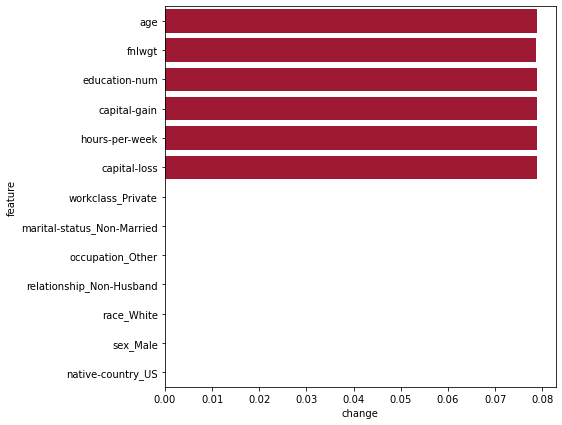

In [11]:
single_sample_plot(factuals.iloc[0], counterfactuals.iloc[0], dataset)

### Summary plot

The second possibility is a summary plot, which is useful to visualize a large number of samples. Again the y-axis shows the features, while the x-axis shows the difference. However here the color coding corresponds to the original feature-value, not positive or negative change. So red means high original feature-value, blue low original feature-value. The plots show the top-n most important features, which is measured by their total absolute change.

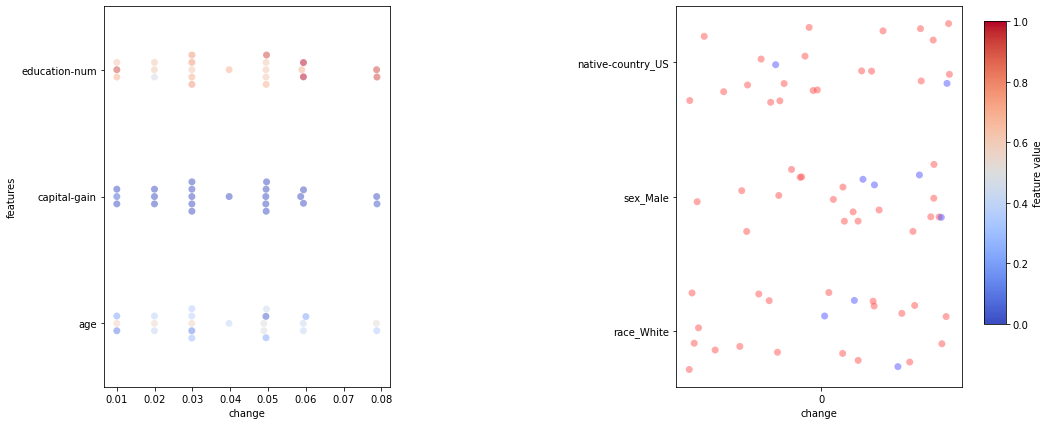

In [12]:
summary_plot(factuals, counterfactuals, dataset, topn=3)

# Showing Wachter on all methods on all datasets with pytorch backend

################################################################################
####dataset: adult, model: ann, recourse method: Wachter
################################################################################


,y-Nearest-Neighbours,L0_distance,L1_distance,L2_distance,Linf_distance,Success_Rate,Redundancy,Constraint_Violation,avg_time
0,0.163636,6.0,0.472695,0.037240,0.078842,1.0,1,1,0.018509
1,NaN,6.0,0.119658,0.002386,0.019956,NaN,5,1,NaN
2,NaN,6.0,0.179093,0.005346,0.029872,NaN,2,1,NaN
3,NaN,6.0,0.356108,0.021136,0.059395,NaN,1,1,NaN
4,NaN,6.0,0.119681,0.002387,0.019958,NaN,5,1,NaN
5,NaN,6.0,0.060000,0.000600,0.010000,NaN,3,1,NaN
6,NaN,6.0,0.295848,0.014588,0.049576,NaN,3,1,NaN
7,NaN,6.0,0.297497,0.014751,0.049617,NaN,1,1,NaN
8,NaN,6.0,0.342862,0.019664,0.060019,NaN,1,1,NaN
9,NaN,6.0,0.296670,0.014669,0.049495,NaN,4,1,NaN


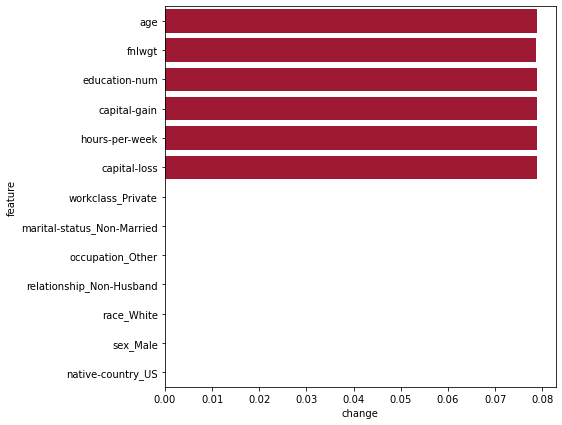

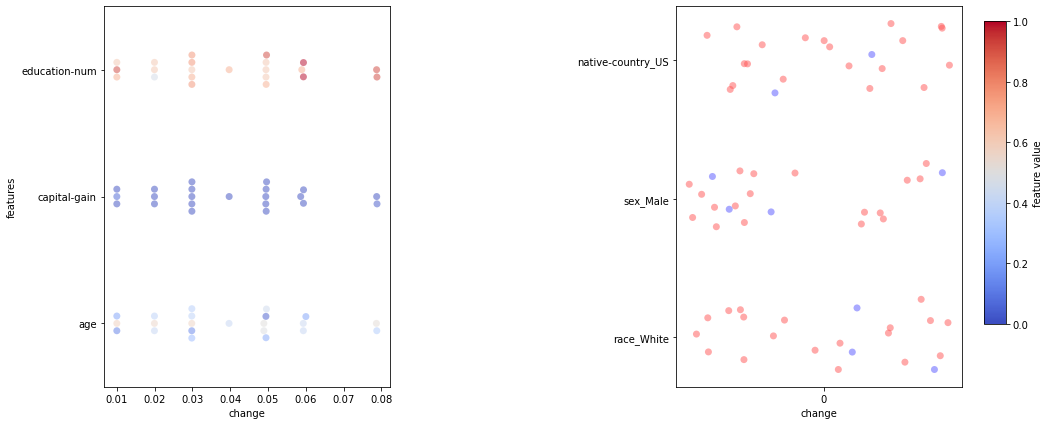

################################################################################
####dataset: adult, model: linear, recourse method: Wachter
################################################################################


,y-Nearest-Neighbours,L0_distance,L1_distance,L2_distance,Linf_distance,Success_Rate,Redundancy,Constraint_Violation,avg_time
0,0.096,6.0,0.644622,0.069259,0.107747,1.0,1,1,0.03493
1,NaN,6.0,1.277153,0.271859,0.213350,NaN,0,1,NaN
2,NaN,6.0,0.529998,0.046818,0.088585,NaN,1,1,NaN
3,NaN,6.0,1.736128,0.502367,0.289979,NaN,1,1,NaN
4,NaN,6.0,0.060000,0.000600,0.010000,NaN,6,1,NaN
5,NaN,6.0,0.296795,0.014682,0.049618,NaN,4,1,NaN
6,NaN,6.0,0.930592,0.144338,0.155512,NaN,1,1,NaN
7,NaN,6.0,0.990482,0.163513,0.165484,NaN,0,1,NaN
8,NaN,6.0,0.238201,0.009457,0.039805,NaN,1,1,NaN
9,NaN,6.0,0.818463,0.111650,0.136758,NaN,1,1,NaN


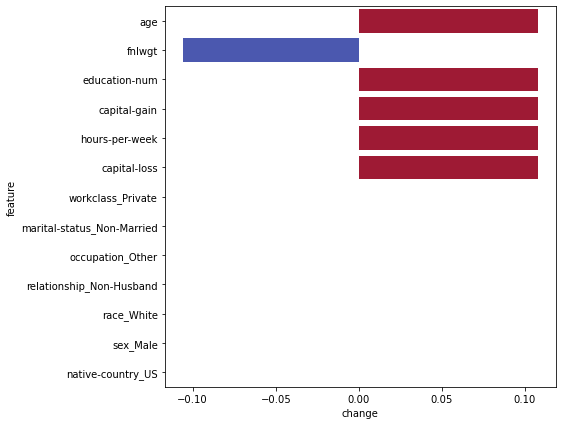

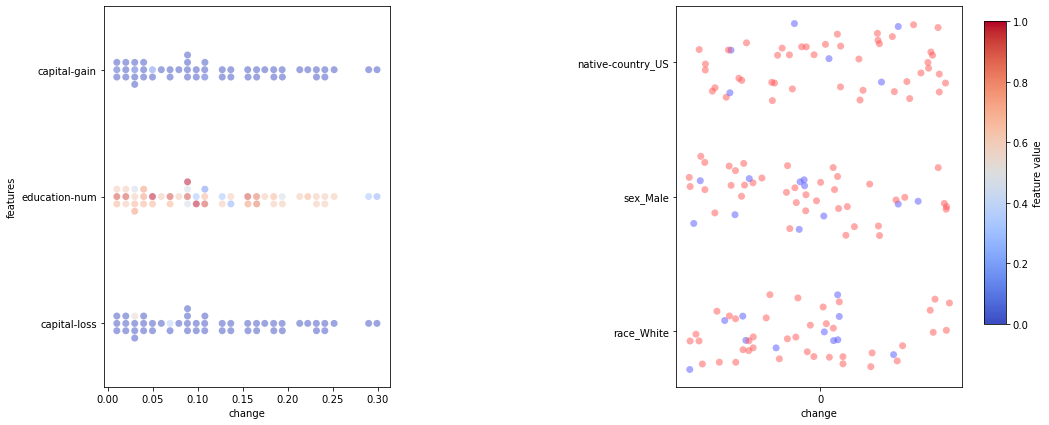

################################################################################
####dataset: compas, model: ann, recourse method: Wachter
################################################################################


,y-Nearest-Neighbours,L0_distance,L1_distance,L2_distance,Linf_distance,Success_Rate,Redundancy,Constraint_Violation,avg_time
0,0.406667,4.0,0.040000,0.000400,0.010000,1.0,4,1,0.011265
1,NaN,4.0,0.119563,0.003574,0.029898,NaN,1,1,NaN
2,NaN,4.0,0.079835,0.001593,0.019962,NaN,1,1,NaN
3,NaN,4.0,0.119341,0.003561,0.029843,NaN,1,1,NaN
4,NaN,4.0,0.159053,0.006324,0.039774,NaN,1,1,NaN
5,NaN,4.0,0.079854,0.001594,0.019967,NaN,4,1,NaN
6,NaN,4.0,0.040000,0.000400,0.010000,NaN,1,1,NaN
7,NaN,4.0,0.040000,0.000400,0.010000,NaN,4,1,NaN
8,NaN,4.0,0.119797,0.003588,0.029965,NaN,0,1,NaN
9,NaN,4.0,0.119793,0.003588,0.029964,NaN,1,1,NaN


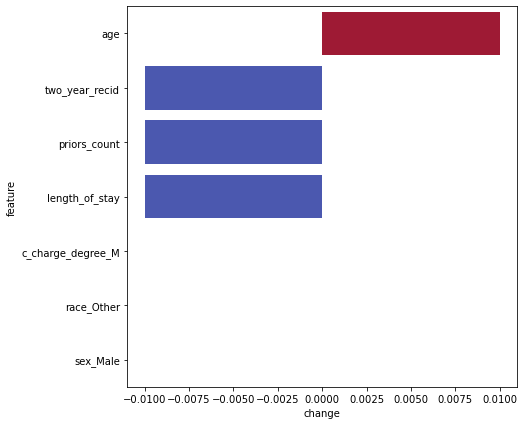

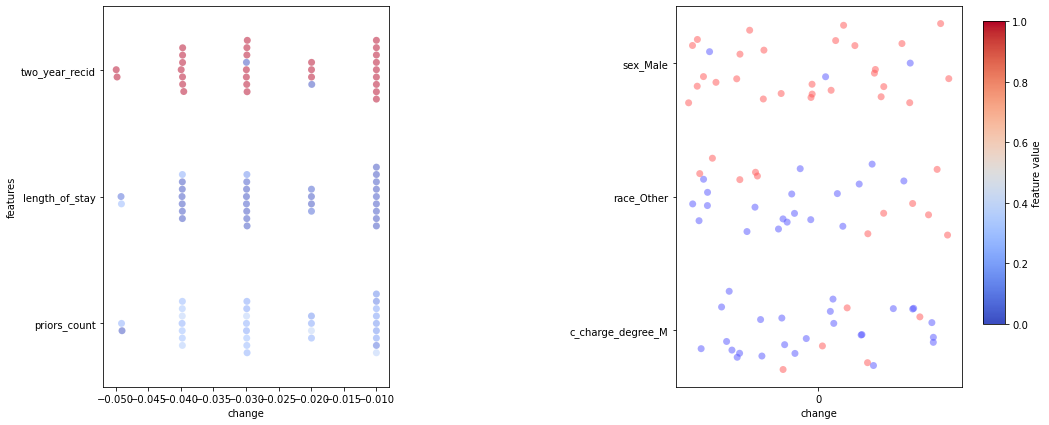

################################################################################
####dataset: compas, model: linear, recourse method: Wachter
################################################################################


,y-Nearest-Neighbours,L0_distance,L1_distance,L2_distance,Linf_distance,Success_Rate,Redundancy,Constraint_Violation,avg_time
0,0.3,4.0,0.394930,0.038992,0.098755,1.0,0,1,0.013306
1,NaN,4.0,0.040000,0.000400,0.010000,NaN,1,1,NaN
2,NaN,4.0,0.238599,0.014232,0.059662,NaN,0,1,NaN
3,NaN,4.0,0.238602,0.014233,0.059662,NaN,0,1,NaN
4,NaN,4.0,0.079927,0.001597,0.019984,NaN,4,1,NaN
5,NaN,4.0,0.624917,0.097630,0.156268,NaN,0,1,NaN
6,NaN,4.0,0.316990,0.025121,0.079265,NaN,0,1,NaN
7,NaN,4.0,0.316983,0.025120,0.079264,NaN,1,1,NaN
8,NaN,4.0,0.040000,0.000400,0.010000,NaN,4,1,NaN
9,NaN,4.0,0.040000,0.000400,0.010000,NaN,4,1,NaN


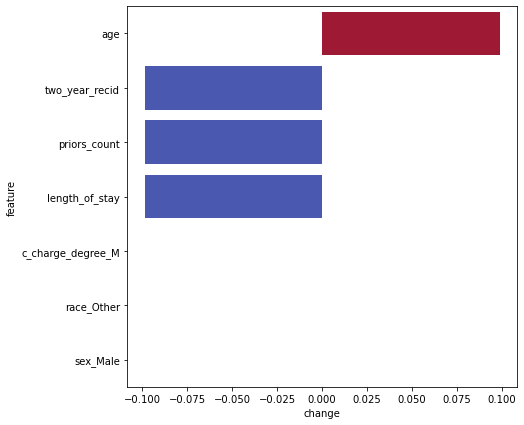

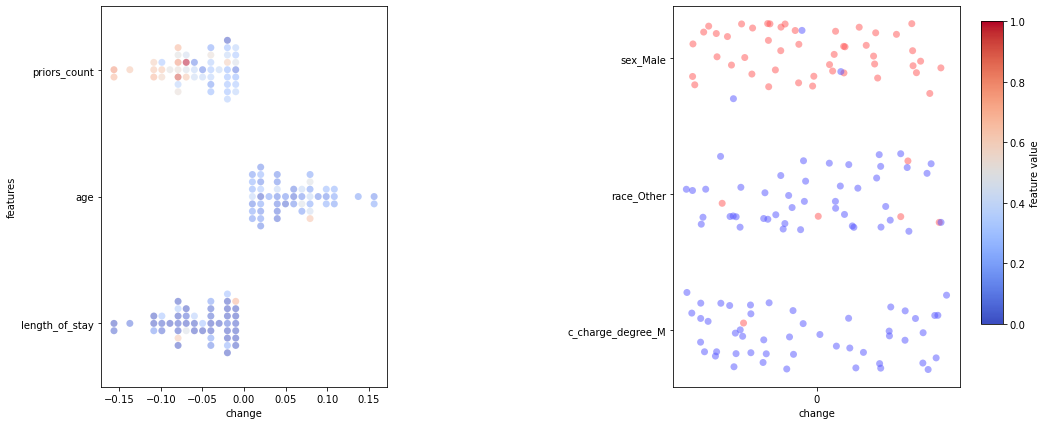

################################################################################
####dataset: give_me_some_credit, model: ann, recourse method: Wachter
################################################################################
!!! No negative classifications ('factuals') found, skipping this evaluation
################################################################################
####dataset: give_me_some_credit, model: linear, recourse method: Wachter
################################################################################


,y-Nearest-Neighbours,L0_distance,L1_distance,L2_distance,Linf_distance,Success_Rate,Redundancy,Constraint_Violation,avg_time
0,0.564,10.0,0.198207,0.003930,0.019962,1.0,10,1.0,0.008076
1,NaN,10.0,0.296378,0.008789,0.029887,NaN,5,1.0,NaN
2,NaN,10.0,2.227823,0.496412,0.223933,NaN,0,1.0,NaN
3,NaN,10.0,0.100000,0.001000,0.010000,NaN,10,1.0,NaN
4,NaN,10.0,0.876987,0.076950,0.088429,NaN,4,1.0,NaN
5,NaN,10.0,0.684924,0.046939,0.069096,NaN,4,1.0,NaN
6,NaN,10.0,0.393961,0.015531,0.039759,NaN,5,1.0,NaN
7,NaN,10.0,0.198459,0.003940,0.019966,NaN,4,1.0,NaN
8,NaN,10.0,0.779527,0.060806,0.078679,NaN,7,1.0,NaN
9,NaN,10.0,0.100000,0.001000,0.010000,NaN,9,1.0,NaN


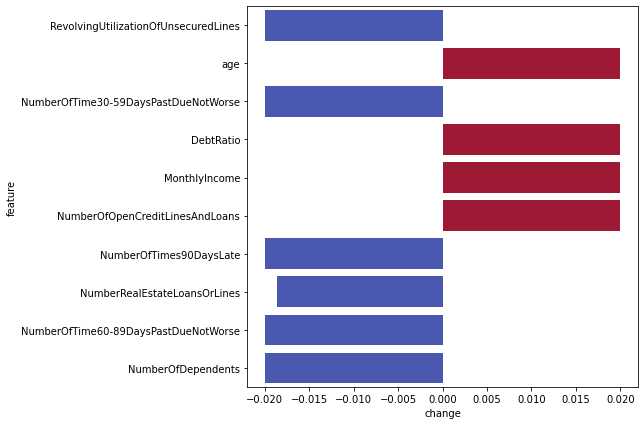

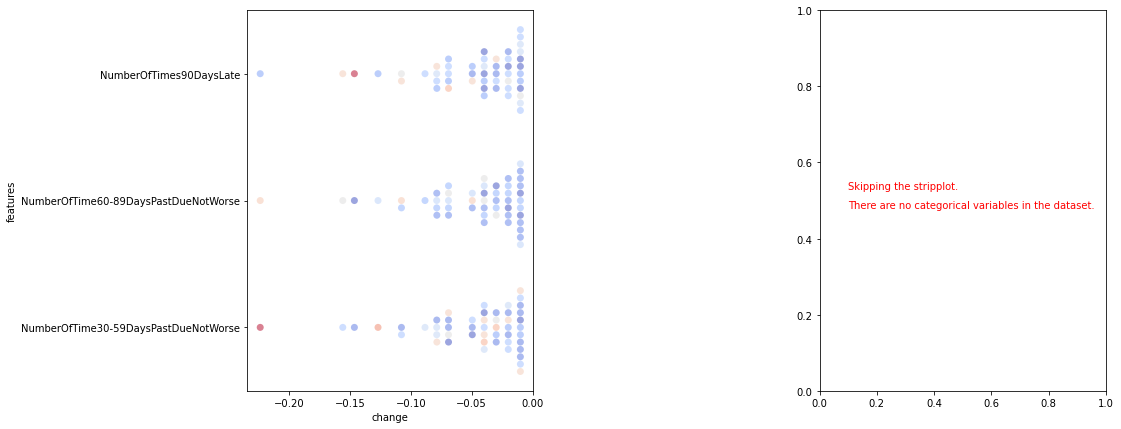

################################################################################
####dataset: heloc, model: ann, recourse method: Wachter
################################################################################
!!! No counterfactuas with now positive classification found, skipping this evaluation
################################################################################
####dataset: heloc, model: linear, recourse method: Wachter
################################################################################


,y-Nearest-Neighbours,L0_distance,L1_distance,L2_distance,Linf_distance,Success_Rate,Redundancy,Constraint_Violation,avg_time
0,0.232,21.0,1.036949,0.051204,0.049464,1.0,20,0.0,0.008212
1,NaN,21.0,0.418298,0.008332,0.019944,NaN,21,0.0,NaN
2,NaN,21.0,1.036822,0.051191,0.049459,NaN,21,0.0,NaN
3,NaN,21.0,1.037879,0.051296,0.049503,NaN,11,0.0,NaN
4,NaN,21.0,1.444807,0.099404,0.068917,NaN,18,0.0,NaN
5,NaN,21.0,2.055952,0.201285,0.098050,NaN,15,0.0,NaN
6,NaN,21.0,0.210000,0.002100,0.010000,NaN,21,0.0,NaN
7,NaN,21.0,0.832205,0.032980,0.039693,NaN,17,0.0,NaN
8,NaN,21.0,1.242159,0.073475,0.059248,NaN,15,0.0,NaN
9,NaN,21.0,1.446232,0.099601,0.068979,NaN,15,0.0,NaN


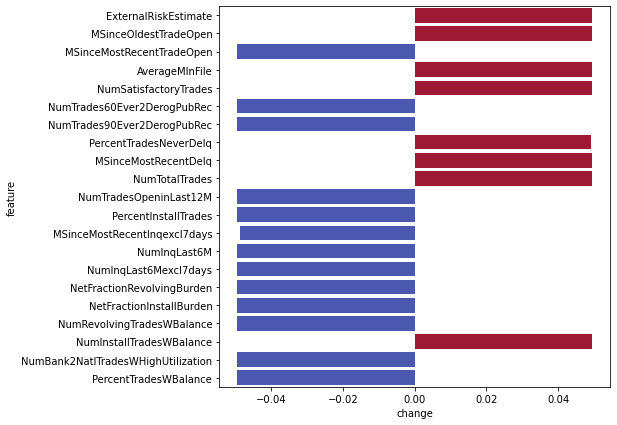

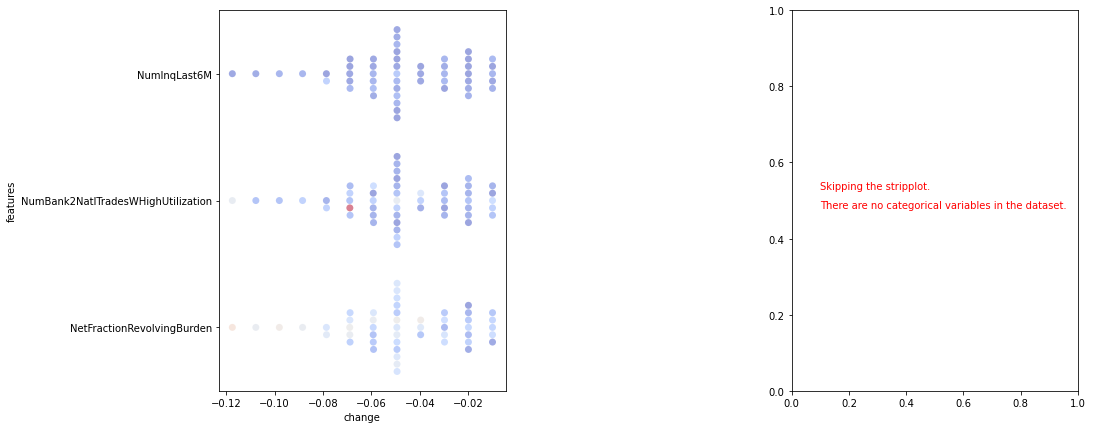

In [13]:
NUM_FACTUALS = 50 # 50

for dataset_name in ["adult", "compas", "give_me_some_credit", "heloc"]:
    for model_type in ["ann", "linear"]:
        # if dataset_name == "give_me_some_credit" and model_type == "ann": # note that the ann model on give_me_some_credit returns a constant value ~0.8029, so there are no negative samples
        #     continue

        dataset = OnlineCatalog(dataset_name)

        ml_model = MLModelCatalog(
            dataset,
            model_type=model_type,
            load_online=True,
            backend="pytorch"
        )


        factuals = predict_negative_instances(ml_model, dataset.df)
        factuals = factuals[:NUM_FACTUALS]



        # Only Wachter:
        recourse_methods = {}
        hyperparams = {"loss_type": "BCE", "binary_cat_features": True, "t_max_min": 0.01, "verbose_logging": False}
        recourse_method = recourse_catalog.Wachter(ml_model, hyperparams)
        recourse_methods.update({"Wachter": recourse_method})

        for recourse_method_name, recourse_method in recourse_methods.items():
            print("#" * 80)
            print("#" * 4 + "dataset: {}, model: {}, recourse method: {}".format(dataset_name, model_type, recourse_method_name))
            print("#"* 80)

            if len(factuals) == 0:
                print("!!! No negative classifications ('factuals') found, skipping this evaluation")
                continue


            counterfactuals = recourse_method.get_counterfactuals(factuals)

            counterfactuals = counterfactuals.dropna()
            factuals = factuals[factuals.index.isin(counterfactuals.index)]

            if len(counterfactuals) == 0:
                print("!!! No counterfactuas with now positive classification found, skipping this evaluation")
                continue


            benchmark = Benchmark(ml_model, recourse_method, factuals)

            evaluation_measures = [
                evaluation_catalog.YNN(benchmark.mlmodel, {"y": 5, "cf_label": 1}),
                evaluation_catalog.Distance(benchmark.mlmodel),
                evaluation_catalog.SuccessRate(),
                evaluation_catalog.Redundancy(benchmark.mlmodel, {"cf_label": 1}),
                evaluation_catalog.ConstraintViolation(benchmark.mlmodel),
                evaluation_catalog.AvgTime({"time": benchmark.timer}),
            ]

            results = benchmark.run_benchmark(evaluation_measures)

            display(results.head(10))
            single_sample_plot(factuals.iloc[0], counterfactuals.iloc[0], dataset)
            plt.show()
            # print(len(factuals))
            # print(len(counterfactuals))
            summary_plot(factuals, counterfactuals, dataset, topn=3)
            plt.show()


### Showing all methods, all datasets and all recourse methods with pytorch backend

In [14]:
NUM_FACTUALS = 50 # 50

for dataset_name in ["adult", "compas", "give_me_some_credit", "heloc"]:
    for model_type in ["ann", "linear"]:
        # if dataset_name == "give_me_some_credit" and model_type == "ann": # note that the ann model on give_me_some_credit returns a constant value ~0.8029, so there are no negative samples
        #     continue

        dataset = OnlineCatalog(dataset_name)

        ml_model = MLModelCatalog(
            dataset,
            model_type=model_type,
            load_online=True,
            backend="pytorch"
        )


        factuals = predict_negative_instances(ml_model, dataset.df)
        factuals = factuals[:NUM_FACTUALS]



        # AR, Causal, CCHVAE, CLUE, CRUDS, DiCE, FACE, Growing Spheres, Revise, Wachter
        recourse_methods = {}

        recourse_method = recourse_catalog.ActionableRecourse(ml_model)
        recourse_methods.update({"ActionableRecourse": recourse_method})

        # # Causal Recourse does not work withoud SCM (structural causal model)
        # hyperparams = {"optimization_approach": "gradient_descent"}
        # recourse_method = recourse_catalog.CausalRecourse(ml_model, hyperparams)
        # recourse_methods.update({"CausalRecourse": recourse_method})

        # # There are errors with tensors on CPU vs GPU for CCHVAE
        # hyperparams = {
        #     "data_name": dataset.name,
        #     "n_search_samples": 100,
        #     "p_norm": 1,
        #     "step": 0.1,
        #     "max_iter": 1000,
        #     "clamp": True,
        #     "binary_cat_features": True,
        #     "vae_params": {
        #         "layers": [len(ml_model.feature_input_order), 512, 256, 8],
        #         "train": True,
        #         "lambda_reg": 1e-6,
        #         "epochs": 5,
        #         "lr": 1e-3,
        #         "batch_size": 32,
        #     },
        # }
        # recourse_method = recourse_catalog.CCHVAE(ml_model, hyperparams)
        # recourse_methods.update({"CCHVAE": recourse_method})

        hyperparams = {"data_name": dataset.name}
        recourse_method = recourse_catalog.Clue(dataset, ml_model, hyperparams)
        recourse_methods.update({"CLUE": recourse_method})

        # Errors with matrix multiplication...
        # hyperparams = {
        #     "data_name": dataset.name,
        #     "vae_params": {
        #         "layers": [len(ml_model.feature_input_order), 512, 256, 8],
        #         "train": True,
        #         "lambda_reg": 1e-6,
        #         "epochs": 5,
        #         "lr": 1e-3,
        #         "batch_size": 32,
        #     },
        # }
        # recourse_method = recourse_catalog.CRUD(ml_model, hyperparams)
        # recourse_methods.update({"CRUDS": recourse_method})

        hyperparams = None
        recourse_method = recourse_catalog.Dice(ml_model, hyperparams)
        recourse_methods.update({"DiCE": recourse_method})

        hyperparams = None
        recourse_method = recourse_catalog.Face(ml_model, hyperparams)
        recourse_methods.update({"FACE": recourse_method})

        hyperparams = None
        recourse_method = recourse_catalog.GrowingSpheres(ml_model, hyperparams)
        recourse_methods.update({"GrowingSpheres": recourse_method})


        # # Tensor problem with VAE on CPU/GPU
        # hyperparams = {
        #     "data_name": dataset.name,
        #     "vae_params": {
        #         "layers": [len(ml_model.feature_input_order), 512, 256, 8],
        #         "train": True,
        #         "lambda_reg": 1e-6,
        #         "epochs": 5,
        #         "lr": 1e-3,
        #         "batch_size": 32,
        #     },
        # }
        # recourse_method = recourse_catalog.Revise(ml_model, dataset, hyperparams)
        # recourse_methods.update({"Revise": recourse_method})

        hyperparams = {"loss_type": "BCE", "binary_cat_features": True, "t_max_min": 0.01, "verbose_logging": False}
        recourse_method = recourse_catalog.Wachter(ml_model, hyperparams)
        recourse_methods.update({"Wachter": recourse_method})

        print(recourse_methods)

        for recourse_method_name, recourse_method in recourse_methods.items():
            print("#" * 80)
            print("#" * 4 + "dataset: {}, model: {}, recourse method: {}".format(dataset_name, model_type, recourse_method_name))
            print("#"* 80)

            if len(factuals) == 0:
                print("!!! No negative classifications ('factuals') found, skipping this evaluation")
                continue


            counterfactuals = recourse_method.get_counterfactuals(factuals)

            counterfactuals = counterfactuals.dropna()
            factuals = factuals[factuals.index.isin(counterfactuals.index)]

            if len(counterfactuals) == 0:
                print("!!! No counterfactuas with now positive classification found, skipping this evaluation")
                continue


            benchmark = Benchmark(ml_model, recourse_method, factuals)

            evaluation_measures = [
                evaluation_catalog.YNN(benchmark.mlmodel, {"y": 5, "cf_label": 1}),
                evaluation_catalog.Distance(benchmark.mlmodel),
                evaluation_catalog.SuccessRate(),
                evaluation_catalog.Redundancy(benchmark.mlmodel, {"cf_label": 1}),
                evaluation_catalog.ConstraintViolation(benchmark.mlmodel),
                evaluation_catalog.AvgTime({"time": benchmark.timer}),
            ]

            results = benchmark.run_benchmark(evaluation_measures)

            display(results.head(10))
            single_sample_plot(factuals.iloc[0], counterfactuals.iloc[0], dataset)
            plt.show()
            # print(len(factuals))
            # print(len(counterfactuals))
            summary_plot(factuals, counterfactuals, dataset, topn=3)
            plt.show()


{'ActionableRecourse': <carla.recourse_methods.catalog.actionable_recourse.model.ActionableRecourse object at 0x000001EA5CB50828>, 'CLUE': <carla.recourse_methods.catalog.clue.model.Clue object at 0x000001EA5CEA3400>, 'DiCE': <carla.recourse_methods.catalog.dice.model.Dice object at 0x000001EA94C49518>, 'FACE': <carla.recourse_methods.catalog.face.model.Face object at 0x000001EA5CE96F60>, 'GrowingSpheres': <carla.recourse_methods.catalog.growing_spheres.model.GrowingSpheres object at 0x000001EABD734F60>, 'Wachter': <carla.recourse_methods.catalog.wachter.model.Wachter object at 0x000001EABD7343C8>}
################################################################################
####dataset: adult, model: ann, recourse method: ActionableRecourse
################################################################################
obtained 100 items in 3.1 seconds
obtained 100 items in 0.8 seconds
obtained 100 items in 0.8 seconds
obtained 100 items in 0.9 seconds
recovered all minimum-cost i

KeyError: '[ 2  3  5  6  7  8  9 10 11] not found in axis'

### ANN on give me some credit returns constant value -> this model probably is not good

In [ ]:
dataset_name = "give_me_some_credit"
model_type="ann"

dataset = OnlineCatalog(dataset_name)

ml_model = MLModelCatalog(
    dataset,
    model_type=model_type,
    load_online=True,
    backend="pytorch"
)

In [ ]:
# no factuals found
factuals = predict_negative_instances(ml_model, dataset.df)
factuals

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,...,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs


In [ ]:
# dataset is nonempty
dataset.df


,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,...,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
0,0.001241,0.260274,0.0,0.000094,0.052261,...,0.0,0.00,0.0,0.25,1
1,0.000854,0.232877,0.1,0.000066,0.061146,...,0.1,0.00,0.0,0.00,1
2,0.000303,0.123288,0.0,0.000028,0.066332,...,0.0,0.00,0.0,0.00,1
3,0.000276,0.726027,0.0,0.000289,0.070352,...,0.0,0.25,0.0,0.25,1
4,0.000979,0.246575,0.0,0.000162,0.070352,...,0.0,0.00,0.0,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...
115522,0.000500,0.397260,0.0,0.000311,0.068342,...,0.0,0.00,0.0,0.00,1
115523,0.000053,0.726027,0.0,0.000173,0.042211,...,0.0,0.25,0.0,0.00,1
115524,0.000389,0.315068,0.0,0.000552,0.112241,...,0.0,0.25,0.0,0.50,1
115525,0.000000,0.123288,0.0,0.000000,0.114894,...,0.0,0.00,0.0,0.00,1


In [ ]:
preds = ml_model.predict(dataset.df)
preds

array([[0.80297333],
       [0.80297333],
       [0.80297333],
       ...,
       [0.80297333],
       [0.80297333],
       [0.80297333]], dtype=float32)

In [ ]:
# There is only one constant prediction
import numpy as np
np.unique(preds, return_counts=True)

(array([0.80297333], dtype=float32), array([115527], dtype=int64))